## 线性回归
    - 线性回归的基本要素
    - 线性回归模型从零开始的实现
    - 线性回归模型使用pytorch的简洁实现

## 线性回归的基本要素

### 模型
为了简单起见，这里我们假设价格只取决于房屋状况的两个因素，即面积（平方米）和房龄（年）。接下来我们希望探索价格与这两个因素的具体关系。线性回归假设输出与各个输入之间是线性关系:


$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$



### 数据集
我们通常收集一系列的真实数据，例如多栋房屋的真实售出价格和它们对应的面积和房龄。我们希望在这个数据上面寻找模型参数来使模型的预测价格与真实价格的误差最小。在机器学习术语里，该数据集被称为训练数据集（training data set）或训练集（training set），一栋房屋被称为一个样本（sample），其真实售出价格叫作标签（label），用来预测标签的两个因素叫作特征（feature）。特征用来表征样本的特点。
### 损失函数
在模型训练中，我们需要衡量价格预测值与真实值之间的误差。通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方函数。 它在评估索引为 $i$ 的样本误差的表达式为


$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$



$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$


### 优化函数 - 随机梯度下降
当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）$\mathcal{B}$，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。   

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$
  
学习率: $\eta$代表在每次优化中，能够学习的步长的大小    
批量大小: $\mathcal{B}$是小批量计算中的批量大小batch size   

总结一下，优化函数的有以下两个步骤：

- (i)初始化模型参数，一般来说使用随机初始化；
- (ii)我们在数据上迭代多次，通过在负梯度方向移动参数来更新每个参数。

**注意**
梯度上升还是梯度下降和目标优化函数是一直的，若想要优化函数越小，则采用梯度下降，若想要优化函数越大，则采用梯度上升

In [1]:
import torch
import time

n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [2]:
# define a timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

In [3]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.08794 sec'

In [4]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00300 sec'

### 线性回归模型从0开始

In [5]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
print(torch.__version__)

1.4.0


#### 生成数据集
使用线性模型随机生成数据集，生成1000个样本数据集，下面是用来生成数据的线性关系

In [6]:
nb_inputs = 2
nb_examples = 1000
# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(nb_examples, nb_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)  # 添加噪音

#### 数据可视化

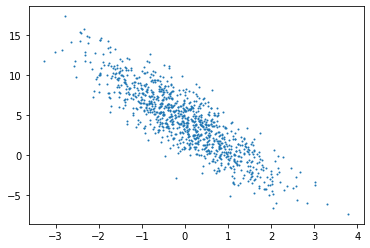

In [7]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

#### 数据读写器

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)  # 进行行维度的选择，即每次选择j行

In [9]:
# test data_iter
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2110,  0.0674],
        [-0.8305,  0.6743],
        [-0.3478,  0.9420],
        [ 1.9382, -0.4983],
        [-1.0234, -0.6619],
        [-0.8195, -3.0215],
        [ 0.0692,  0.5660],
        [ 0.7709, -1.1119],
        [ 0.3937,  0.7820],
        [-0.1800,  0.2354]]) 
 tensor([ 4.3886,  0.2436,  0.2964,  9.7705,  4.4152, 12.8332,  2.4064,  9.5423,
         2.3240,  3.0581])


#### 初始化模型参数

In [16]:
w = torch.tensor(np.random.normal(0, 0.01, (nb_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
print(w,b)
w.requires_grad_(requires_grad=True)  # 是否参与梯度下降
b.requires_grad_(requires_grad=True)

tensor([[0.0068],
        [0.0024]]) tensor([0.])


tensor([0.], requires_grad=True)

#### 定义模型
使用简单的线性归回

In [11]:
def linreg(X, w, b):
    return torch.mm(X, w) + b  # 矩阵乘法+广播机制

#### 定义损失函数
**问题2**

In [22]:
def squared_loss(y_hat, y):   # 均方误差
#     return (y_hat - y.view(y_hat.size())) ** 2 / 2
    return (y_hat.view(-1) - y) ** 2 / 2
#     return -(y_hat - y.view(-1)) ** 2 / 2  # 
#     return (y_hat - y.view(y_hat.shape)) ** 2 / 2
#     return (y_hat - y.view(-1, 1)) ** 2 / 2

#### 定义优化函数

In [23]:
# 这里采用优化函数使用的是小批量随机梯度下降
def sgd(params, lr, batch_size): 
    for param in params:
        param.data += lr * param.grad / batch_size # ues .data to operate param without gradient track

#### 训练

In [25]:
# super parameters init
lr = 0.03 # learning rate
num_epochs = 5

net = linreg
loss = squared_loss
timer = Timer()
# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum() 
        
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
'%.5f sec' % timer.stop()  
#     print(net(features, w, b).shape, labels.shape) # 所以labels需要扩展
#     print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
# print(net(features, w, b).shape, labels.shape)

'0.37577 sec'

**问题3**

In [38]:
squared_loss(torch.Tensor([2.33, 1.07, 1.23]), torch.Tensor([3.14, 0.98, 1.32])).sum()/3

tensor(0.1121)

### 线性模型pytorch简洁实现

In [30]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(2020)

torch.set_default_tensor_type('torch.FloatTensor')

#### 生成数据集
和之前一样

#### 使用utils.data读取数据集

In [31]:
import torch.utils.data as Data

In [32]:
batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,  # 使用多线程读取
)

In [33]:
## 测试
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.6414,  0.0122],
        [ 0.4468, -2.6335],
        [-0.3769,  0.4390],
        [-1.1532,  0.2595],
        [-1.7146, -0.1833],
        [ 0.1806, -0.4321],
        [ 0.8752,  1.1701],
        [-0.8961, -1.3425],
        [ 0.5695, -1.0889],
        [ 0.4538, -0.5142]]) 
 tensor([ 5.4475, 14.0564,  1.9508,  1.0137,  1.4047,  6.0302,  1.9873,  6.9710,
         9.0265,  6.8472])


#### 模型定义

In [34]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(nb_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [35]:
## 扩展为多层序列模型
# 方式1
net = nn.Sequential(
    nn.Linear(nb_inputs, 1)
)
# 方式2
net = nn.Sequential()
net.add_module('linear', nn.Linear(nb_inputs, 1))
# 方法3
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(nb_inputs, 1))
          # ......
        ]))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


#### 初始化模型参数

In [36]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [37]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0016,  0.0022]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


#### 调用损失函数

In [38]:
loss = nn.MSELoss()

#### 定义优化函数

In [39]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


#### 训练

In [41]:
timer = Timer()
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
'%.5f sec' % timer.stop()
#     print('epoch %d, loss: %f' % (epoch, l.item()))

'15.34452 sec'

In [53]:
## 结果对比
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0005, -3.3993]])
4.2 tensor([4.1998])


### 两种方式对比
- 从0开始可以理解Linear Regression的模型原理，pytorch可以加快模型构建
- 时间上，pytorch的编码并没有提升